In [ ]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [4]:
#importing libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, confusion_matrix

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
#generating GRB peak with poisson noise


def gen_signal(N, x0, w, A, bkg, peak=False):
    x = np.arange(N)
    y = np.ones(N) * bkg 
    
    if peak:
        y_peak = np.exp(-(x-x0)/w) * A
        y_peak[:x0] = 0
        y += y_peak
        
    y = np.random.poisson(y)

    return x, y

In [7]:
#random constant vales

#Number of data
N_data = 10000
df = pd.DataFrame(columns=["x0", "w", "A", "bkg", "GRB"], index=range(N_data))

for i in range(N_data):
    df["x0"].loc[i] = np.random.randint(10, 50)
    df["w"].loc[i] = np.random.uniform(10, 20)
    df["A"].loc[i] = np.random.uniform(10, 20)
    df["bkg"].loc[i] = np.random.uniform(7,10)
    df["GRB"].loc[i] = [True, False][np.random.randint(2)]
    
df

,x0,w,A,bkg,GRB
0,13,12.973497,14.059678,8.220066,True
1,24,18.622201,17.503844,7.343498,True
2,26,14.209374,12.845655,9.803412,True
3,29,12.823481,19.340419,8.903448,True
4,43,10.817624,19.618775,9.245562,True
...,...,...,...,...,...
9995,40,19.421701,15.271551,8.699061,False
9996,28,11.564013,18.638999,7.03339,True
9997,41,19.716714,13.726129,9.894227,True
9998,26,18.657527,15.068179,7.819658,True


In [8]:
#generating random data

#duration of peak window
N_tu = 128

data = []
for i in range(N_data):
    data.append(gen_signal(N=N_tu, 
                           x0=df.x0.loc[i], 
                           w=df.w.loc[i], 
                           A=df.A.loc[i], 
                           bkg=df.bkg.loc[i], 
                           peak=df.GRB.loc[i])[1])

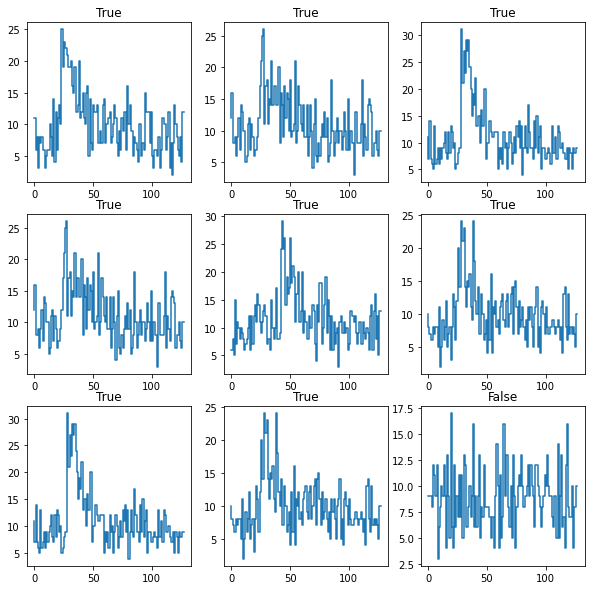

In [9]:
#plot of some curves
x = np.arange(N_tu)

fig, axs = plt.subplots(3,3,figsize=(10,10))
for i in range(3):
    for j in range(3):
        ind = (i+1)*(j+1)
        axs[i,j].set_title(df.GRB.loc[ind])
        axs[i,j].step(x, data[ind])

In [10]:
X = np.array(data).reshape(-1, N_tu, 1).astype(np.float32)
y = df.GRB

#encode target labels with value between 0 and n_classes-1
le = LabelEncoder()

#fit label encoder
le.fit(y)


#transform labels to normalized encoding (True = 1, False = 0)
y = le.transform(y) 

#splits data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420)

In [11]:
model = Sequential()
model.add(Conv1D(64, 5, padding='same', activation='relu', input_shape=(N_tu, 1)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

2022-04-25 22:49:05.875762: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 22:49:05.877367: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 64)           384       
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 2,098,049
Trainable params: 2,098,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
          validation_data = (X_test, y_test),
          batch_size=10, epochs=15)

2022-04-25 22:49:10.689663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-25 22:49:10.715731: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/15
750/750 [==============================] - 22s 28ms/step - loss: 0.7409 - accuracy: 0.8919 - val_loss: 0.0529 - val_accuracy: 0.9784
Epoch 2/15
750/750 [==============================] - 22s 30ms/step - loss: 0.0431 - accuracy: 0.9845 - val_loss: 0.0338 - val_accuracy: 0.9904
Epoch 3/15
  3/750 [..............................] - ETA: 33s - loss: 0.0035 - accuracy: 1.0000

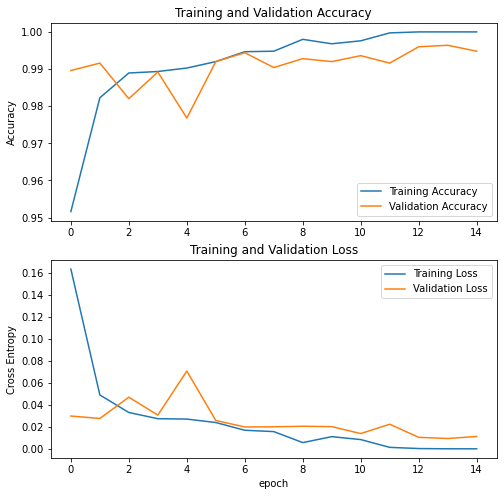

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Number of falsely identified: 13 out of: 2500


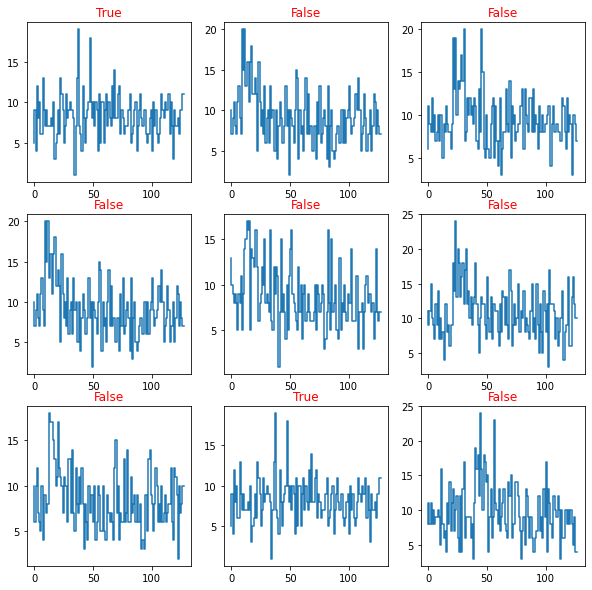

In [13]:
#predicting 
y_pred = model.predict(X_test).reshape(-1)

#(True = 1, False = 0)
threshold = 0.5
y_pred = np.where(y_pred <= threshold, 0, 1)

colors = {True : "green", False : "red"}

#index of falsely identified
indices = np.nonzero(y_pred != y_test)[0]
print('Number of falsely identified:',len(indices), "out of:", len(y_test))

#example of falsely identified
fig, axs = plt.subplots(3,3,figsize=(10,10))
for i in range(3):
    for j in range(3):
        ind = np.random.choice(indices)
        color = colors[y_pred[ind] == y_test[ind]]
        axs[i,j].set_title(bool(y_pred[ind]), color=color)
        axs[i,j].step(x, X_test[ind])


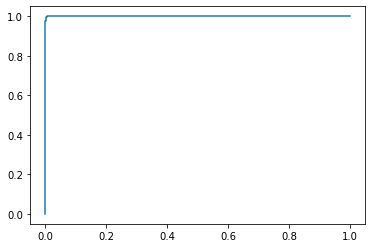

In [14]:
#ROC curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras)

In [15]:
#heatmap of success

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions >= p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    print('Total: ', np.sum(cm[1]))
plot_cm(y_test, y_pred_keras)

NameError: name 'sns' is not defined

<Figure size 360x360 with 0 Axes>